# Start with adversarial images in a simple linear classifier
Following http://karpathy.github.io/2015/03/30/breaking-convnets/

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def linear(input, output_dim, scope=None):
    norm = tf.random_normal_initializer()
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b

Create a model with 784 inputs connecting directly to 10 softmax outputs

In [3]:
class Linear(object):
    def __init__(self, num_steps, batch_size, log_every):
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.log_every = log_every
        self.hidden_size = 100
        
        self._create_model()
        
    def _create_model(self):
        with tf.variable_scope('InOut'):
            self.x = tf.placeholder(tf.float32, shape=(None, 784))
            self.t = tf.placeholder(tf.float32, shape=(None, 10))
        with tf.variable_scope('Hidden'):
            self.y = linear(self.x, 10)
        with tf.variable_scope('Opt'):
            self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y, labels=self.t))
            self.optimizer = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
            correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.t,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def fool_model(self,imgs,target):
        with tf.variable_scope('Image'):
            img = tf.constant(imgs)
            t = np.zeros([10,10],dtype='float32')
            t[:,target] = 1
            t = tf.constant(t)
           
            self.two = tf.get_variable('imgs', initializer=img)
            self.six = tf.get_variable('targets', initializer=t)
        with tf.variable_scope('Hidden',reuse=True):
            self.y = linear(self.two, 10)
        with tf.variable_scope('Opt'):
            self.vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='Image')

            self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y, labels=self.six))
            self.optimizer = tf.train.AdamOptimizer(1e-3).minimize(self.cross_entropy, var_list=self.vars)
            correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.six,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def train(self):
        with tf.Session() as session:
            tf.global_variables_initializer().run()
            
            for i in range(self.num_steps):
                batch = mnist.train.next_batch(self.batch_size)
                if i%100 == 0:
                    train_accuracy = session.run(self.accuracy, feed_dict={self.x:batch[0], self.t: batch[1]})
                    print("step %d, training accuracy %g"%(i, train_accuracy))
                session.run([self.cross_entropy,self.optimizer], feed_dict={self.x: batch[0], self.t: batch[1]})
            saver = tf.train.Saver()
            save_path = saver.save(session, "./data/Linear.weights")
            print("Model saved in file: %s" % save_path)
            print("test accuracy %g"%session.run(self.accuracy, feed_dict={self.x:mnist.test.images, self.t: mnist.test.labels}))
            
    def fool(self,images,target=6):
        with tf.Session() as session:
            saver = tf.train.Saver()
            save_path = saver.restore(session, "./data/Linear.weights")
            self.fool_model(twos,target)
            
            tf.global_variables_initializer().run()
            
            for i in range(300):
                CE,ACC,Y,_ = session.run([self.cross_entropy,self.accuracy,self.y,self.optimizer])
                print("step %d, cross entropy %g, training accuracy %g"%(i, CE, ACC))
                if i%10 == 0:
                    print(Y[0])
                if ACC==1.0:
                    break
            
            return session.run(self.two)

In [4]:
model = Linear(1000,100,100)
model.train()

step 0, training accuracy 0.07
step 100, training accuracy 0.11
step 200, training accuracy 0.07
step 300, training accuracy 0.06
step 400, training accuracy 0.08
step 500, training accuracy 0.08
step 600, training accuracy 0.09
step 700, training accuracy 0.09
step 800, training accuracy 0.12
step 900, training accuracy 0.06
Model saved in file: ./data/Linear.weights
test accuracy 0.1063


Pick 10 images correctly classified as 2. 

Perform a simple manipulation of adding 5% weights of class 6 to the images. 
Images classified as 6. 

The output confidence level changed drastically. (First example)

In [5]:
twos = mnist.test.images[mnist.test.labels[:,2]==1]
with tf.Session() as session:
    saver = tf.train.Saver()
    save_path = saver.restore(session, "./data/Linear.weights")
    w = session.run(tf.trainable_variables()[0])
    b = session.run(tf.trainable_variables()[1])
    twos = twos[np.argmax(session.run(model.y, feed_dict={model.x:twos}),axis=1)==2][:10]
    twos_manip = twos+0.05*w[:,6]
    y = session.run(model.y, feed_dict={model.x:twos})
    print(np.argmax(y,axis=1))
    print(y[0])
    y_manip = session.run(model.y, feed_dict={model.x:twos_manip})
    print(np.argmax(y_manip,axis=1))
    print(y_manip[0])
    

[2 2 2 2 2 2 2 2 2 2]
[  1.37011325  -1.17666888  17.00790405  -3.58261704  -4.97182989
   0.79552352  -4.17475891  -6.57424498   5.61446905  -1.24553585]
[6 6 6 6 6 6 6 6 6 6]
[ -0.24344645  -3.4881804   14.4940958   -4.83608389  -2.35134363
   2.57191515  39.5546608   -6.30170631   5.12255478   0.39041591]


Take a look at the images, the first row are the originals, the second row are the adversarial images after manipulation

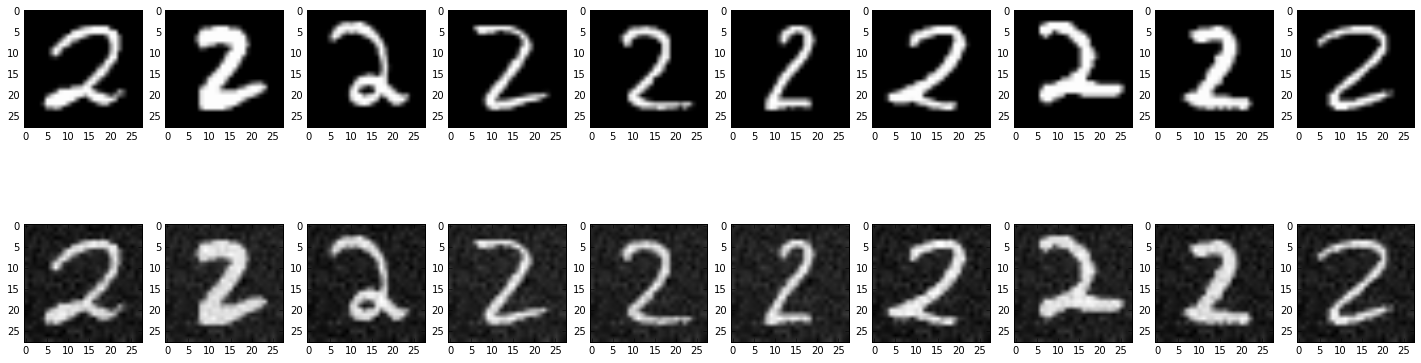

In [6]:
fig, axes = plt.subplots(figsize=(20, 6))
fig.tight_layout()
for i,img in enumerate(twos):
    ax = plt.subplot(2,10,i+1)
    plt.imshow(img.reshape(28,28),cmap='gray')
for i,img in enumerate(twos_manip):
    ax = plt.subplot(2,10,i+11)
    plt.imshow(img.reshape(28,28),cmap='gray')

The difference between each pair of examples are the same in this simple case

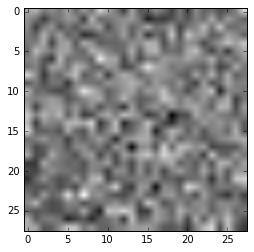

In [7]:
plt.imshow(w[:,6].reshape(28,28),cmap='gray')

In [8]:
new_twos = model.fool(twos)

step 0, cross entropy 9.21359, training accuracy 0
[-3.77926445  6.54801083  8.39066696 -0.24411392 -7.075243   -1.06756735
 -6.57616711 -2.08050108  2.26886845 -3.80185056]
step 1, cross entropy 8.37471, training accuracy 0
step 2, cross entropy 7.55506, training accuracy 0
step 3, cross entropy 6.76301, training accuracy 0.1
step 4, cross entropy 6.01032, training accuracy 0.1
step 5, cross entropy 5.3098, training accuracy 0.2
step 6, cross entropy 4.6702, training accuracy 0.3
step 7, cross entropy 4.09279, training accuracy 0.3
step 8, cross entropy 3.57506, training accuracy 0.5
step 9, cross entropy 3.1133, training accuracy 0.5
step 10, cross entropy 2.70159, training accuracy 0.5
[-3.83000231  4.97852516  4.8860569  -0.44613791 -6.67752361 -0.85279393
 -0.95020247 -1.85279799  2.15755725 -3.41242218]
step 11, cross entropy 2.33482, training accuracy 0.7
step 12, cross entropy 2.01086, training accuracy 0.7
step 13, cross entropy 1.72822, training accuracy 0.7
step 14, cross en

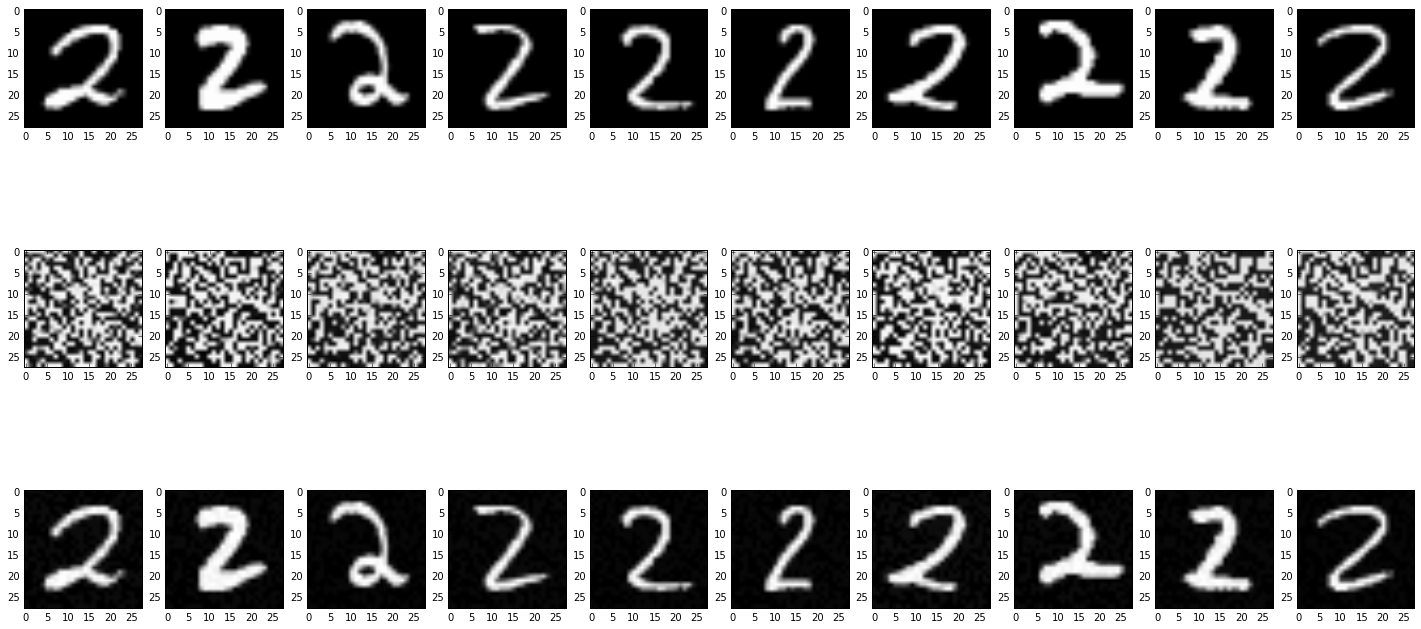

In [15]:
fig, axes = plt.subplots(figsize=(20, 10))
fig.tight_layout()
for i,img in enumerate(twos):
    ax = plt.subplot(3,10,i+1)
    plt.imshow(img.reshape(28,28),cmap='gray')
for i,img in enumerate(new_twos):
    ax = plt.subplot(3,10,i+11)
    plt.imshow((img-twos[i]).reshape(28,28),cmap='gray')
for i,img in enumerate(new_twos):
    ax = plt.subplot(3,10,i+21)
    plt.imshow(img.reshape(28,28),cmap='gray')

In [10]:
def conv_relu(input, kernel_shape, bias_shape, scope=None):
    with tf.variable_scope(scope or 'conv_relu'):
        w = tf.get_variable("w", kernel_shape, initializer=tf.random_normal_initializer())
        b = tf.get_variable("b", bias_shape, initializer=tf.constant_initializer(0.0))
        conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding='SAME')
        return tf.nn.relu(conv + b)

def max_pool_2x2(x, scope=None):
    with tf.variable_scope(scope or 'max_pool_2x2'):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
def drop_out(input, keep_prob, scope=None):
    with tf.variable_scope(scope or 'drop_out'):
        return tf.nn.dropout(input, keep_prob)

In [11]:
class CNN(object):
    def __init__(self, num_steps, batch_size, log_every):
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.log_every = log_every
        self.hidden_size = 100
        
        self._create_model()
        
    def _create_model(self):
        with tf.variable_scope('InOut'):
            self.x = tf.placeholder(tf.float32, shape=(None, 784))
            self.t = tf.placeholder(tf.float32, shape=(None, 10))
        with tf.variable_scope('Hidden'):
            self.conv1 = conv_relu(tf.reshape(self.x,[-1,28,28,1]), [5,5,1,32], 32,'conv1')
            self.pool1 = max_pool_2x2(self.conv1,'pool1')
            self.conv2 = conv_relu(self.pool1, [5,5,32,64], 64,'conv2')
            self.pool2 = max_pool_2x2(self.conv2,'pool2')
            self.fc1 = linear(tf.reshape(self.pool2, [-1, 7*7*64]),1024,'fc1')
            self.keep_prob = tf.placeholder(tf.float32)
            self.drop = drop_out(self.fc1,self.keep_prob,'drop')
            self.y = linear(self.drop,10,'fc2')
        with tf.variable_scope('Opt'):
            self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y, labels=self.t))
            self.optimizer = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
            correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.t,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def fool_model(self,imgs,target):#TODU
        with tf.variable_scope('Image'):
            img = tf.constant(imgs)
            t = np.zeros([10,10],dtype='float32')
            t[:,target] = 1
            t = tf.constant(t)
           
            self.two = tf.get_variable('imgs', initializer=img)
            self.six = tf.get_variable('targets', initializer=t)
        with tf.variable_scope('Hidden',reuse=True):
            self.y = linear(self.two, 10)
        with tf.variable_scope('Opt'):
            self.vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='Image')

            self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.y, labels=self.six))
            self.optimizer = tf.train.AdamOptimizer(1e-3).minimize(self.cross_entropy, var_list=self.vars)
            correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.six,1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def train(self):
        with tf.Session() as session:
            tf.global_variables_initializer().run()
            
            for i in range(self.num_steps):
                batch = mnist.train.next_batch(self.batch_size)
                if i%100 == 0:
                    train_accuracy = session.run(self.accuracy, \
                                                 feed_dict={self.x:batch[0], self.t: batch[1],self.keep_prob:1.0})
                    print("step %d, training accuracy %g"%(i, train_accuracy))
                session.run([self.cross_entropy,self.optimizer], \
                            feed_dict={self.x: batch[0], self.t: batch[1],self.keep_prob:0.5})
            saver = tf.train.Saver()
            save_path = saver.save(session, "./data/CNN.weights")
            print("Model saved in file: %s" % save_path)
            print("test accuracy %g"%session.run(self.accuracy, \
                                                 feed_dict={self.x:mnist.test.images, self.t: mnist.test.labels,self.keep_prob:1.0}))
            
    def fool(self,images,target=6):#TODO
        with tf.Session() as session:
            saver = tf.train.Saver()
            save_path = saver.restore(session, "./data/CNN.weights")
            self.fool_model(twos,target)
            
            tf.global_variables_initializer().run()
            
            for i in range(300):
                CE,ACC,Y,_ = session.run([self.cross_entropy,self.accuracy,self.y,self.optimizer])
                print("step %d, cross entropy %g, training accuracy %g"%(i, CE, ACC))
                if i%10 == 0:
                    print(Y[0])
                if ACC==1.0:
                    break
            
            return session.run(self.two)

In [12]:
model = CNN(2000,100,100)

In [13]:
model.train()

step 0, training accuracy 0.13
step 100, training accuracy 0.34
step 200, training accuracy 0.56
step 300, training accuracy 0.66
step 400, training accuracy 0.73
step 500, training accuracy 0.77
step 600, training accuracy 0.81
step 700, training accuracy 0.78
step 800, training accuracy 0.91
step 900, training accuracy 0.92
step 1000, training accuracy 0.89
step 1100, training accuracy 0.85
step 1200, training accuracy 0.91
step 1300, training accuracy 0.91
step 1400, training accuracy 0.9
step 1500, training accuracy 0.91
step 1600, training accuracy 0.89
step 1700, training accuracy 0.94
step 1800, training accuracy 0.94
step 1900, training accuracy 0.88
Model saved in file: ./data/CNN.weights
test accuracy 0.9276
